In [1]:
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
import tensorflow.keras.backend as kb

import time
import datetime
import json
import os
import pandas as pd
import sys
import pysam
from scipy.special import logsumexp
import imageio

from plotnine import *

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import tensorflow as tf
import tensorflow.keras.backend as kb

from tensorflow.keras import Model
import tensorflow_probability as tfp

class CustomModel(Model):

    def __init__(self, num_tasks, tracks_for_each_task, output_profile_len, loss_weights,counts_loss, **kwargs):

        # call the base class with inputs and outputs
        super(CustomModel, self).__init__(**kwargs)
        
        # number of tasks
        self.num_tasks = num_tasks
        
        # number of tracks for each task
        self.tracks_for_each_task = tracks_for_each_task
        
        # output profile length
        self.output_profile_len = output_profile_len
        
        # weights for the profile mnll and logcounts losses
        self.loss_weights = loss_weights
        
        # logcounts loss funtion
        self.counts_loss = counts_loss
        
        # object to track overall mean loss per epoch
        self.loss_tracker = keras.metrics.Mean(name="loss")


    def _get_loss(self, x, y, sample_weights, training=True):
        # boolean mask for sample weights != 0
        
                
        y_pred = self(x, training=training)  # Forward pass
        
        
        def poisson_loss_function(y_log_true, y_log_pred):
            # we can use the Possion PMF from TensorFlow as well
            # dist = tf.contrib.distributions
            # return -tf.reduce_mean(dist.Poisson(y_pred).log_pmf(y_true))

            # last term can be avoided since it doesn't depend on y_pred
            # however keeping it gives a nice lower bound to zero
            
            y_true = tf.math.exp(y_log_true)
            y_pred = tf.math.exp(y_log_pred)
            y_true = tf.cast(y_true,tf.float32)
            y_pred = tf.cast(y_pred,tf.float32)
            loss = y_pred - y_true*tf.math.log(y_pred+1e-8) + tf.math.lgamma(y_true+1.0)

            return loss
        
        def _poisson_loss_function(_y_log_true,_y_log_pred):
            total_poisson_loss = 0
            track_count_cuml = 0
            num_tasks_count_cuml = 0
            for i in range(self.num_tasks):
                num_of_tracks = self.tracks_for_each_task[i]
                y_log_true = tf.reduce_logsumexp(_y_log_true[:,track_count_cuml:(track_count_cuml+num_of_tracks)],axis=1)
                y_log_pred = tf.reduce_logsumexp(_y_log_pred[:,num_tasks_count_cuml:(num_tasks_count_cuml+1)],axis=1)
                
                loss = poisson_loss_function(y_log_true, y_log_pred)
                track_count_cuml += num_of_tracks
                num_tasks_count_cuml += 1
                total_poisson_loss += loss
            return total_poisson_loss
    
        def mse_loss_function(y_log_true, y_log_pred):
            # logcounts mse loss without sample weights
            mse_loss = keras.losses.mean_squared_error(
                y_log_true, y_log_pred)
            return mse_loss
        
        def _mse_loss_function(_y_log_true,_y_log_pred):
            total_mse_loss = 0
            track_count_cuml = 0
            num_tasks_count_cuml = 0
            for i in range(self.num_tasks):
                num_of_tracks = self.tracks_for_each_task[i]
                y_log_true = tf.reduce_logsumexp(_y_log_true[:,track_count_cuml:(track_count_cuml+num_of_tracks)],axis=1)
                y_log_pred = tf.reduce_logsumexp(_y_log_pred[:,num_tasks_count_cuml:(num_tasks_count_cuml+1)],axis=1)
                
                loss = mse_loss_function(y_log_true, y_log_pred)
                track_count_cuml += num_of_tracks
                num_tasks_count_cuml += 1
                total_mse_loss += loss
            return total_mse_loss
        
        if self.counts_loss == "MSE":
            total_counts_loss = _mse_loss_function(y['logcounts_predictions'],y_pred[1])
        
        elif self.counts_loss == "POISSON":
        
            total_counts_loss = _poisson_loss_function(y['logcounts_predictions'],y_pred[1])
            
        else:
            raise Exception("Sorry, unknown loss funtion")
        
        boolean_mask = tf.math.greater_equal(sample_weights, 1.0)

        # for mnll loss we mask out samples with weight == 0.0
        
        _y = tf.boolean_mask(y['profile_predictions'], boolean_mask)
        _y_pred = tf.boolean_mask(y_pred[0], boolean_mask)

        def _zero_constant():
            return kb.constant(0)
        def multinomial_nll(true_counts, logits):
            """Compute the multinomial negative log-likelihood
            Args:
              true_counts: observed count values
              logits: predicted logits values
            """
            counts_per_example = tf.reduce_sum(true_counts, axis=-1)
            dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                                 logits=logits)
            return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
                    tf.cast(tf.shape(true_counts)[0], dtype=tf.float32))
    
        def _multinomial_nll(_y,_y_pred):
            total_mnll_loss = 0
            track_count_cuml = 0
            for i in range(self.num_tasks):
                num_of_tracks = self.tracks_for_each_task[i]
                _y_reshape = tf.reshape(\
                                        _y[:,:,track_count_cuml:(track_count_cuml+num_of_tracks)],\
                                        [-1,(num_of_tracks)*(self.output_profile_len)]\
                                       )
                _y_pred_reshape = tf.reshape(\
                                             _y_pred[:,:,track_count_cuml:(track_count_cuml+num_of_tracks)],\
                                             [-1,(num_of_tracks)*(self.output_profile_len)]\
                                            )
                
                loss = multinomial_nll(_y_reshape, _y_pred_reshape)
                track_count_cuml = track_count_cuml+num_of_tracks
                total_mnll_loss += loss
            return total_mnll_loss
                    
        total_mnll_loss = tf.cond(tf.equal(tf.size(_y), 0), 
                  _zero_constant,
                  lambda:  _multinomial_nll(_y,_y_pred))
        
        if self.counts_loss == "MSE":
            loss =  (self.loss_weights[0] * total_mnll_loss) + \
                (self.loss_weights[1] * total_counts_loss)        
        elif self.counts_loss == "POISSON":
        
            loss =  total_mnll_loss + total_counts_loss            
        else:
            raise Exception("Sorry, unknown loss funtion")

        return loss, total_mnll_loss, total_counts_loss
            
    def train_step(self, data):
        x, y, sample_weights = data
        print(kb.int_shape(x['sequence']))
        print(kb.int_shape(y['profile_predictions']))
        print(kb.int_shape(y['logcounts_predictions']))
        print(kb.int_shape(sample_weights))        
    
        with tf.GradientTape() as tape:
            loss, total_mnll_loss, total_counts_loss = \
                self._get_loss(x, y, sample_weights)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result(),
                "batch_loss": loss,
                "profile_predictions_loss": total_mnll_loss, 
                "logcounts_predictions_loss": total_counts_loss}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker]
    
    
    def test_step(self, data):
        # Unpack the data
        x, y, sample_weights = data
        
        loss, total_mnll_loss, total_counts_loss = \
            self._get_loss(x, y, sample_weights, training=False)
            
        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result(),
                "batch_loss": loss,
                "profile_predictions_loss": total_mnll_loss, 
                "logcounts_predictions_loss": total_counts_loss}
    
def get_model(model_path):
    with CustomObjectScope({'MultichannelMultinomialNLL': lambda n='0':n,
                            "kb": kb,
                            "CustomMeanSquaredError":lambda n='0':n,
                            "tf":tf,
                           "CustomModel":CustomModel}):
        model = load_model(model_path)
    return model



def random_seq(seqlen):
    return ''.join(random.choices("ACGT", k=seqlen))



def fix_sequence_length(sequence, length):
    """
        Function to check if length of sequence matches specified
        length and then return a sequence that's either padded or
        truncated to match the given length
        Args:
            sequence (str): the input sequence
            length (int): expected length
        Returns:
            str: string of length 'length'
    """

    # check if the sequence is smaller than expected length
    if len(sequence) < length:
        # pad the sequence with 'N's
        sequence += 'N' * (length - len(sequence))
    # check if the sequence is larger than expected length
    elif len(sequence) > length:
        # truncate to expected length
        sequence = sequence[:length]

    return sequence
def one_hot_encode(sequences, seq_length):
    """
    
       One hot encoding of a list of DNA sequences 
       
       Args:
           sequences (list): python list of strings of equal length
           seq_length (int): expected length of each sequence in the 
               list
           
       Returns:
           numpy.ndarray: 
               3-dimension numpy array with shape 
               (len(sequences), len(list_item), 4)
    """
    
    if len(sequences) == 0:
        logging.error("'sequences' is empty")
        return None
    
    # First, let's make sure all sequences are of equal length
    sequences = list(map(
        fix_sequence_length, sequences, [seq_length] * len(sequences)))

    # Step 1. convert sequence list into a single string
    _sequences = ''.join(sequences)
    
    # Step 2. translate the alphabet to a string of digits
    transtab = str.maketrans('ACGTNYRMSWK', '01234444444')    
    sequences_trans = _sequences.translate(transtab)
    
    # Step 3. convert to list of ints
    int_sequences = list(map(int, sequences_trans))
    
    # Step 4. one hot encode using int_sequences to index 
    # into an 'encoder' array
    encoder = np.vstack([np.eye(4), np.zeros(4)])
    X = encoder[int_sequences]

    # Step 5. reshape 
    return X.reshape(len(sequences), len(sequences[0]), 4)



In [2]:
model_h5="/oak/stanford/groups/akundaje/vir/tfatlas/models/production_run_1/fold0/ENCSR124AIG/ENCSR124AIG_split000.h5"

model = get_model(model_path=model_h5)

/users/anusri/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: genomicsdlarchsandlosses.bpnet.archs is not loaded, but a Lambda layer uses it. It may cause errors.


In [4]:
import numpy as np
import random
output_seq_len = 1000
number_of_strands = 2

def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

output_len=1000
#option 2
def vectorized_prediction_to_profile(predictions):
        logits_arr = predictions[0]
        counts_arr = predictions[1]
        pred_profile_logits = np.reshape(logits_arr,[-1,1,output_len*2])
        probVals_array = np.exp(pred_profile_logits-logsumexp(pred_profile_logits,axis=2).reshape([len(logits_arr),1,1]))
        profile_predictions = np.multiply((np.exp(counts_arr)).reshape([len(counts_arr),1,1]),probVals_array)
        plus = np.reshape(profile_predictions,[len(counts_arr),output_len,2])[:,:,0]
        minus = np.reshape(profile_predictions,[len(counts_arr),output_len,2])[:,:,1]
        return(plus,minus)
    
    

def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    
    encoded_inserted_sequences = w_mot_seqs

    predictions = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],output_seq_len,number_of_strands)),    
               np.zeros(encoded_inserted_sequences.shape[0]*number_of_strands).reshape((encoded_inserted_sequences.shape[0],number_of_strands))])

    plus_fwd,minus_fwd = vectorized_prediction_to_profile(predictions)


    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    
    encoded_inserted_sequences = w_mot_seqs_revc

    predictions = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],output_seq_len,number_of_strands)),    
               np.zeros(encoded_inserted_sequences.shape[0]*number_of_strands).reshape((encoded_inserted_sequences.shape[0],number_of_strands))])

    plus_rev,minus_rev = vectorized_prediction_to_profile(predictions)

    
    counts_for_motif = np.sum(plus_fwd,axis=-1)+np.sum(minus_rev,axis=-1)
    plus_tot = (plus_fwd+minus_rev[:,::-1])/2
    minus_tot = (minus_fwd+plus_rev[:,::-1])/2

    print(plus_tot.shape)
    plus_tot_prob =  plus_tot / plus_tot.sum(axis=1)[:, np.newaxis]
    minus_tot_prob =  minus_tot / minus_tot.sum(axis=1)[:, np.newaxis]

    counts_plus = (np.sum(plus_fwd,axis=-1)+np.sum(minus_rev,axis=-1))/2
    counts_minus = (np.sum(minus_fwd,axis=-1)+np.sum(plus_rev,axis=-1))/2

    return [plus_tot_prob.mean(0), counts_plus.mean(0), minus_tot_prob.mean(0), counts_minus.mean(0)]

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    
    encoded_inserted_sequences = w_mot_seqs

    predictions = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],output_seq_len,number_of_strands)),    
               np.zeros(encoded_inserted_sequences.shape[0]*number_of_strands).reshape((encoded_inserted_sequences.shape[0],number_of_strands))])

    plus_fwd,minus_fwd = vectorized_prediction_to_profile(predictions)

    
    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]

    encoded_inserted_sequences = w_mot_seqs_revc
    predictions = model.predict([encoded_inserted_sequences,
               np.zeros(output_seq_len*number_of_strands*encoded_inserted_sequences.shape[0]).reshape((encoded_inserted_sequences.shape[0],output_seq_len,number_of_strands)),    
               np.zeros(encoded_inserted_sequences.shape[0]*number_of_strands).reshape((encoded_inserted_sequences.shape[0],number_of_strands))])

    plus_rev,minus_rev = vectorized_prediction_to_profile(predictions)
    
    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.sum(plus_fwd,axis=-1)+np.sum(minus_rev,axis=-1)
    plus_tot = plus_fwd+minus_rev[:,::-1]
    minus_tot = minus_fwd+plus_rev[:,::-1]
    counts_plus = np.sum(plus_tot,axis=-1)
    counts_minus = np.sum(minus_tot,axis=-1)
    plus_prof = plus_tot / plus_tot.sum(axis=-1)[:, np.newaxis]
    minus_prof = minus_tot / minus_tot.sum(axis=-1)[:, np.newaxis]
    

    return [plus_prof.mean(0), counts_plus.mean(0), minus_prof.mean(0), counts_minus.mean(0)]

In [5]:
regions="/oak/stanford/groups/akundaje/vir/tfatlas/models/production_run_1/fold0/ENCSR124AIG/ENCSR124AIG_background_regions.bed"


In [6]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [7]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import one_hot as dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
#chroms_to_keep = ["chr1"]
regions_subsample = regions_df.sample(100, random_state=0)
genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

In [14]:
motifs = ["AGGAATGT","TTGACTCA"]
batch_size=250
output_len=1000
data_in_spacings = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-1*spacing)
    data_in_spacings.append([puu_runx_footprint[1],puu_runx_footprint[3]])

AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061


In [15]:
motifs = ["AGGAATGT","TTGACTCA"]

data_in_spacings_rev = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=spacing)
    data_in_spacings_rev.append([puu_runx_footprint[1],puu_runx_footprint[3]])

AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061
AGGAATGT 1053 1061


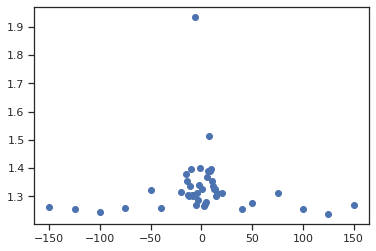

In [18]:
all_counts = [x[0] for x in data_in_spacings]
all_counts_rev = [x[0] for x in data_in_spacings_rev]
all_counts_min = [x[1] for x in data_in_spacings]
all_counts_rev_min = [x[1] for x in data_in_spacings_rev]


plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev+all_counts)


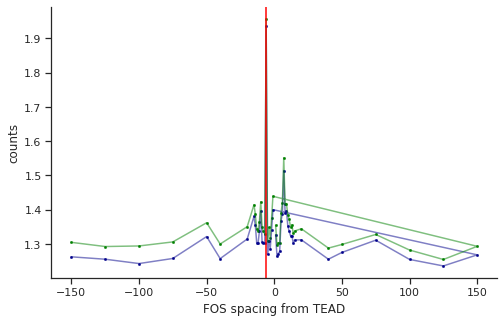

In [20]:

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("ticks", {'axes.grid' : False})

# plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:], linewidths=0.5, edgecolors=None,s=5)
# plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:], alpha=0.5 )

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev[0:]+all_counts[0:], linewidths=0.5, edgecolors=None,s=5, c="#00008B")
ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev[0:]+all_counts[0:], alpha=0.5 , c="#00008B")
ax.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev_min[0:]+all_counts_min[0:], linewidths=0.5, edgecolors=None,s=5, c="green")
ax.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150],all_counts_rev_min[0:]+all_counts_min[0:], alpha=0.5 , c="green")


# Dataset
# x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40,50,75,100,125, 150]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40, -50, -75, -100, -125, -150])
# y = np.array(all_counts[::-1]+all_counts_rev)

#X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
# X_ = np.linspace(x.min(), x.max(), 500)
#Y_ = X_Y_Spline(X_)

ax.axvline(-6, color="orange", linestyle="-", c="red")  #vertical line
#plt.plot(X_,Y_)
ax.set_ylabel("counts")
ax.set_xlabel("FOS spacing from TEAD")
ax.spines[['right', 'top']].set_visible(False)


plt.savefig("subfigs/ap1_tead_syntax_chip.pdf", transparent=True, dpi=300)

